<a href="https://colab.research.google.com/github/lutho278/AI-AUDIT-BIAS/blob/main/loan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Step 1: Install and import required libraries
!pip install aif360 scikit-learn matplotlib pandas numpy

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# AIF360 Core Imports
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing

# For visualization
import matplotlib.pyplot as plt

print("✅ All libraries installed and imported successfully!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.7/259.7 kB 9.4 MB/s eta 0:00:00


pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'


✅ All libraries installed and imported successfully!


In [ ]:
# Step 2: Create synthetic biased data
np.random.seed(42)

n = 5000
income = np.random.normal(50000, 20000, n).astype(int)
credit_score = np.random.normal(650, 100, n).astype(int)
employment_years = np.random.exponential(5, n).astype(int)

group = np.random.choice([0, 1], n, p=[0.7, 0.3])  # 0: Unprivileged, 1: Privileged

true_eligibility = (income > 45000) & (credit_score > 600)
approval_chance = true_eligibility.astype(float)
approval_chance[group == 0] *= 0.7  # Introduce bias against unprivileged group

approved = np.random.binomial(1, approval_chance)

df = pd.DataFrame({
    'income': income,
    'credit_score': credit_score,
    'employment_years': employment_years,
    'race': group,
    'approved': approved
})

print("📊 First 5 rows of data:")
print(df.head())
print(f"\n📈 Approval rate for privileged group: {df[df['race']==1]['approved'].mean():.3f}")
print(f"📉 Approval rate for unprivileged group: {df[df['race']==0]['approved'].mean():.3f}")

# Calculate the bias
privileged_rate = df[df['race']==1]['approved'].mean()
unprivileged_rate = df[df['race']==0]['approved'].mean()
bias_ratio = unprivileged_rate / privileged_rate
print(f"🚨 Bias Ratio (Unprivileged/Privileged): {bias_ratio:.3f}")

📊 First 5 rows of data:
   income  credit_score  employment_years  race  approved
0   59934           607                 1     0         1
1   47234           604                 0     0         1
2   62953           470                 0     0         0
3   80460           616                 0     1         1
4   45316           723                 4     1         1

📈 Approval rate for privileged group: 0.405
📉 Approval rate for unprivileged group: 0.299
🚨 Bias Ratio (Unprivileged/Privileged): 0.737


### Bias Metrics on the Original Training Data ###
Disparate Impact (ideal=1.0): 0.7456
Statistical Parity Difference (ideal=0.0): -0.1060


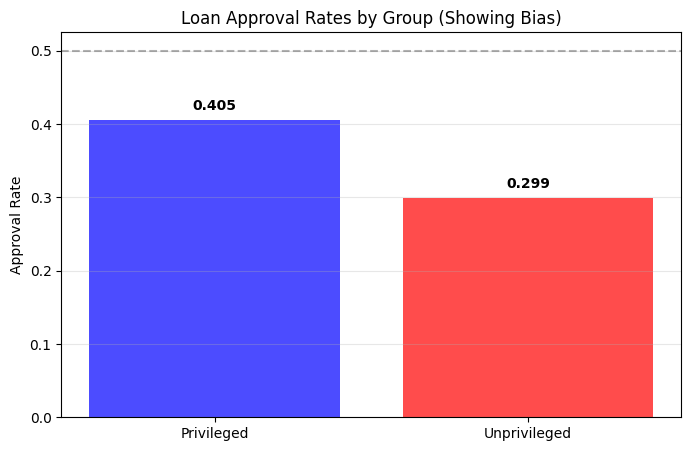

In [ ]:
# Step 3: Set up the fairness dataset and check for bias
privileged_groups = [{'race': 1}]
unprivileged_groups = [{'race': 0}]

dataset = BinaryLabelDataset(
    df=df,
    label_names=['approved'],
    protected_attribute_names=['race'],
    favorable_label=1,
    unfavorable_label=0
)

dataset_train, dataset_test = dataset.split([0.7], shuffle=True)

metric_orig_train = BinaryLabelDatasetMetric(
    dataset_train,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
)

print("### Bias Metrics on the Original Training Data ###")
print(f"Disparate Impact (ideal=1.0): {metric_orig_train.disparate_impact():.4f}")
print(f"Statistical Parity Difference (ideal=0.0): {metric_orig_train.statistical_parity_difference():.4f}")

# Quick visualization
groups = ['Privileged', 'Unprivileged']
approval_rates = [df[df['race']==1]['approved'].mean(), df[df['race']==0]['approved'].mean()]

plt.figure(figsize=(8, 5))
bars = plt.bar(groups, approval_rates, color=['blue', 'red'], alpha=0.7)
plt.ylabel('Approval Rate')
plt.title('Loan Approval Rates by Group (Showing Bias)')
plt.axhline(y=0.5, color='black', linestyle='--', alpha=0.3)
for i, v in enumerate(approval_rates):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.show()

In [ ]:
# Step 4: Mitigate the bias using Reweighing
print("🛠️ Applying bias mitigation...")
RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
dataset_transf_train = RW.fit_transform(dataset_train)

metric_transf_train = BinaryLabelDatasetMetric(
    dataset_transf_train,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
)

print("### Bias Metrics on the Transformed (De-biased) Training Data ###")
print(f"Disparate Impact: {metric_transf_train.disparate_impact():.4f}")
print(f"Statistical Parity Difference: {metric_transf_train.statistical_parity_difference():.4f}")

improvement = metric_transf_train.disparate_impact() - metric_orig_train.disparate_impact()
print(f"📈 Improvement in Disparate Impact: {improvement:+.4f}")

🛠️ Applying bias mitigation...
### Bias Metrics on the Transformed (De-biased) Training Data ###
Disparate Impact: 1.0000
Statistical Parity Difference: -0.0000
📈 Improvement in Disparate Impact: +0.2544


In [ ]:
# Step 5: Train and compare both models
scaler = StandardScaler()

# Prepare original data
X_train_orig = dataset_train.features
y_train_orig = dataset_train.labels.ravel()
X_test_orig = dataset_test.features
y_test_orig = dataset_test.labels.ravel()

X_train_orig_scaled = scaler.fit_transform(X_train_orig)
X_test_orig_scaled = scaler.transform(X_test_orig)

# Prepare transformed data
X_train_transf = dataset_transf_train.features
y_train_transf = dataset_transf_train.labels.ravel()
sample_weights_transf = dataset_transf_train.instance_weights
X_train_transf_scaled = scaler.transform(X_train_transf)

# Train models
print("🤖 Training models...")
model_orig = LogisticRegression(random_state=42)
model_orig.fit(X_train_orig_scaled, y_train_orig)

model_transf = LogisticRegression(random_state=42)
model_transf.fit(X_train_transf_scaled, y_train_transf, sample_weight=sample_weights_transf)

# Make predictions
y_pred_orig = model_orig.predict(X_test_orig_scaled)
y_pred_transf = model_transf.predict(X_test_orig_scaled)

print("✅ Models trained and predictions made!")

🤖 Training models...
✅ Models trained and predictions made!



🎯 FINAL COMPARISON: ORIGINAL vs DE-BIASED MODEL
Metric                                   Original     De-biased    Ideal   
------------------------------------------------------------------------
Accuracy:                                0.7893       0.7813       Higher
Disparate Impact:                        0.6065       0.7552       1.0
Statistical Parity Difference:           -0.1352      -0.0736      0.0
Equal Opportunity Difference:            -0.2948      -0.1761      0.0


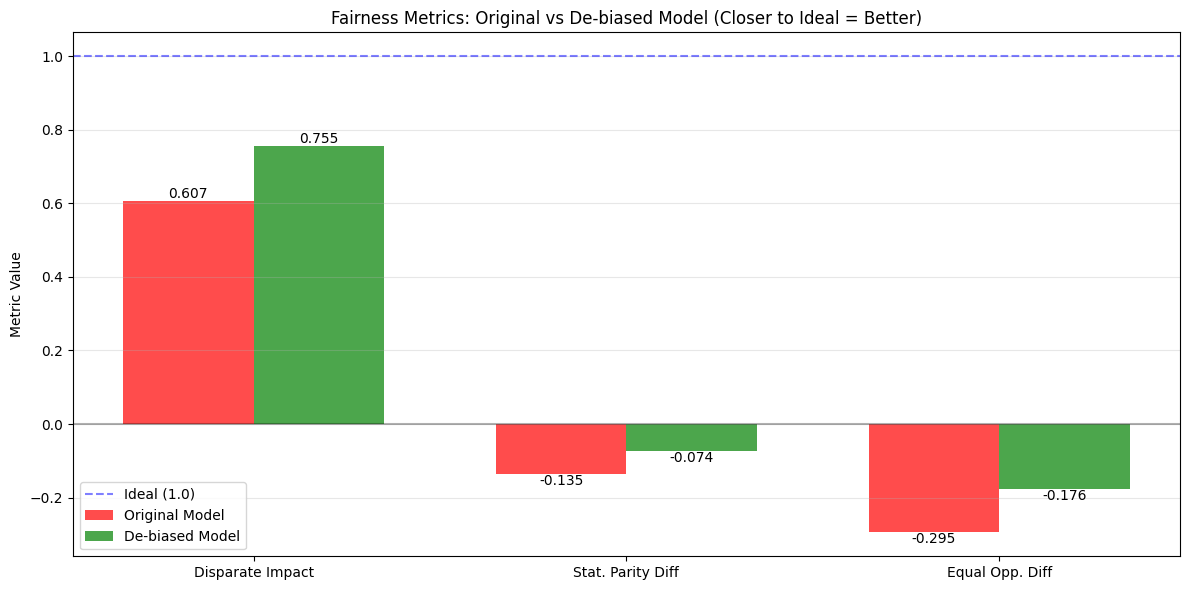


🎉 Analysis complete! The de-biased model should show:
   • Fairness metrics much closer to ideal values
   • Small trade-off in accuracy for major fairness gains
   • More equitable outcomes across groups


In [ ]:
# Step 6: Compare results
dataset_test_pred_orig = dataset_test.copy()
dataset_test_pred_orig.labels = y_pred_orig

dataset_test_pred_transf = dataset_test.copy()
dataset_test_pred_transf.labels = y_pred_transf

classified_metric_orig = ClassificationMetric(
    dataset_test, dataset_test_pred_orig,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
)

classified_metric_transf = ClassificationMetric(
    dataset_test, dataset_test_pred_transf,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
)

print("\n" + "="*60)
print("🎯 FINAL COMPARISON: ORIGINAL vs DE-BIASED MODEL")
print("="*60)
print(f"{'Metric':<40} {'Original':<12} {'De-biased':<12} {'Ideal':<8}")
print("-"*72)
print(f"{'Accuracy:':<40} {accuracy_score(y_test_orig, y_pred_orig):<12.4f} {accuracy_score(y_test_orig, y_pred_transf):<12.4f} {'Higher'}")
print(f"{'Disparate Impact:':<40} {classified_metric_orig.disparate_impact():<12.4f} {classified_metric_transf.disparate_impact():<12.4f} {'1.0'}")
print(f"{'Statistical Parity Difference:':<40} {classified_metric_orig.statistical_parity_difference():<12.4f} {classified_metric_transf.statistical_parity_difference():<12.4f} {'0.0'}")
print(f"{'Equal Opportunity Difference:':<40} {classified_metric_orig.equal_opportunity_difference():<12.4f} {classified_metric_transf.equal_opportunity_difference():<12.4f} {'0.0'}")

# Final visualization
metrics = ['Disparate Impact', 'Stat. Parity Diff', 'Equal Opp. Diff']
original_vals = [
    classified_metric_orig.disparate_impact(),
    classified_metric_orig.statistical_parity_difference(),
    classified_metric_orig.equal_opportunity_difference()
]
debiased_vals = [
    classified_metric_transf.disparate_impact(),
    classified_metric_transf.statistical_parity_difference(),
    classified_metric_transf.equal_opportunity_difference()
]

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(12, 6))
bars1 = plt.bar(x - width/2, original_vals, width, label='Original Model', alpha=0.7, color='red')
bars2 = plt.bar(x + width/2, debiased_vals, width, label='De-biased Model', alpha=0.7, color='green')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.axhline(y=1, color='blue', linestyle='--', alpha=0.5, label='Ideal (1.0)')
plt.ylabel('Metric Value')
plt.title('Fairness Metrics: Original vs De-biased Model (Closer to Ideal = Better)')
plt.xticks(x, metrics)
plt.legend()
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom' if height > 0 else 'top')

plt.tight_layout()
plt.show()

print("\n🎉 Analysis complete! The de-biased model should show:")
print("   • Fairness metrics much closer to ideal values")
print("   • Small trade-off in accuracy for major fairness gains")
print("   • More equitable outcomes across groups")